### Rotation into stream progentior frame

Creating a plotting function

In [219]:
from scipy.spatial.transform import Rotation
import numpy as np
import scipy
import pathlib
import h5py

import astropy.units as u
from astropy.stats import median_absolute_deviation as mad_
from astropy.coordinates import CartesianRepresentation, SphericalRepresentation
import gala.dynamics as gd
import gala.coordinates as gc
import yaml

import matplotlib
import matplotlib.pyplot as plt
import os
os.environ["PATH"] += os.pathsep + "/Library/TeX/texbin"
plt.style.use('my_standard.mplstyle')

galcen_v_sun = (11.1, 245, 7.3)*u.km/u.s
galcen_distance = 8.249*u.kpc

Code to add lengths and widths to hdf5 files

In [162]:
# for i in range(0, 128):
#     stream = "stream_{}.hdf5".format(i)
#     with h5py.File("/mnt/ceph/users/rbrooks/oceanus/analysis/stream-runs/full-mwh-full-mwd-no-lmc/" + stream, 'a') as file:
        
#         ds = np.linalg.norm(file["positions"][-1],axis=1)
#         length = np.nanpercentile(ds, 95) - np.nanpercentile(ds, 5)
        
#         prog = gd.PhaseSpacePosition(file["positions"][-1, 0] * u.kpc, file["velocities"][-1, 0] * u.km / u.s)
#         stream = gd.PhaseSpacePosition(file["positions"][-1, 1:].T * u.kpc, file["velocities"][-1, 1:].T * u.km / u.s)
#         R1 = Rotation.from_euler("z", -prog.spherical.lon.degree, degrees=True)
#         R2 = Rotation.from_euler("y", prog.spherical.lat.degree, degrees=True)
#         R_prog0 = R2.as_matrix() @ R1.as_matrix()  

#         new_vxyz = R_prog0 @ prog.v_xyz
#         v_angle = np.arctan2(new_vxyz[2], new_vxyz[1])
#         R3 = Rotation.from_euler("x", -v_angle.to_value(u.degree), degrees=True)
#         R = (R3 * R2 * R1).as_matrix()

#         stream_rot = gd.PhaseSpacePosition(stream.data.transform(R))
#         stream_sph = stream_rot.spherical
#         lon = stream_sph.lon.wrap_at(180*u.deg).degree[:-2]
#         lat = stream_sph.lat.degree[:-2]
#         width = mad_(lat, ignore_nan=True)
        
#         if 'length' in file:
#             del file['length']
#         if 'width' in file:
#             del file['width']
        
#         # Write the datasets
#         file.create_dataset('length', data=length)
#         file.create_dataset('width', data=width)
        

(-90.0, 90.0)

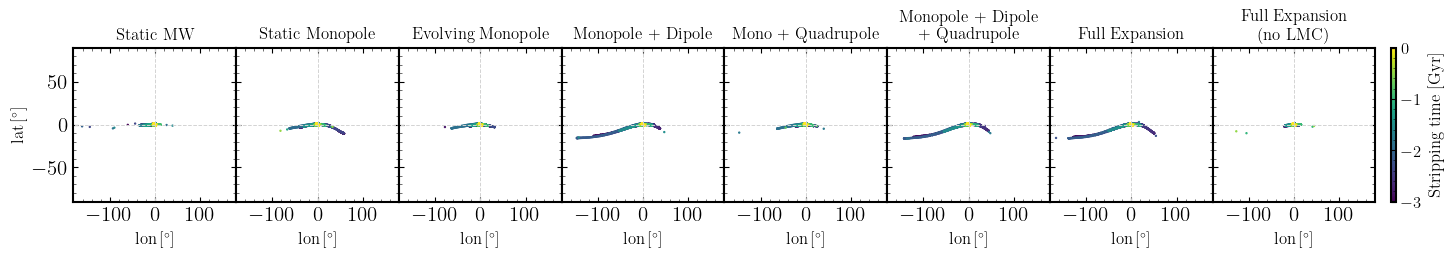

In [2]:
potentials = list(['gd1-static-mw.hdf5','gd1-rm-mwh-full-mwd-full-lmc.hdf5', 'gd1-em-mwh-full-mwd-full-lmc.hdf5', 'gd1-md-mwh-full-mwd-full-lmc.hdf5', \
                       'gd1-mq-mwh-full-mwd-full-lmc.hdf5', 'gd1-mdq-mwh-full-mwd-full-lmc.hdf5', 'gd1-full-mwh-full-mwd-full-lmc.hdf5', \
                       'gd1-full-mwh-full-mwd-no-lmc.hdf5'])
    
labels = list(['Static MW','Static Monopole', 'Evolving Monopole', 'Monopole + Dipole', 'Monopole + Quadrupole', \
               'Monopole + Dipole \n + Quadrupole', 'Full Expansion', 'Full Expansion \n (no LMC)'])

t_idx = -1

fig, ax = plt.subplots(1, len(potentials), sharex='col', sharey='row', figsize=(20,2)) 
plt.subplots_adjust(hspace=0, wspace=0.)
    
for j in range(len(potentials)): 

    #-------------------------------------------------------------------------------------
    ### Read in the data
    #-------------------------------------------------------------------------------------
    data_path = "/mnt/ceph/users/rbrooks/oceanus/analysis/stream-runs/gd1/" + potentials[j]
    with h5py.File(data_path,'r') as file:

        prog = gd.PhaseSpacePosition(file["positions"][t_idx, 0] * u.kpc, file["velocities"][t_idx, 0] * u.km / u.s)
        stream = gd.PhaseSpacePosition(file["positions"][t_idx, 1:].T * u.kpc, file["velocities"][t_idx, 1:].T * u.km / u.s)
        start_times = np.array(file['times'])
        prog_mass = np.array(file['progenitor-mass']) * u.Msun
    #-------------------------------------------------------------------------------------
    ### Rotation matrix for progenitor to get it to near (X, 0, 0)
    #-------------------------------------------------------------------------------------
    R1 = Rotation.from_euler("z", -prog.spherical.lon.degree, degrees=True)
    R2 = Rotation.from_euler("y", prog.spherical.lat.degree, degrees=True)
    R_prog0 = R2.as_matrix() @ R1.as_matrix()  
    #-------------------------------------------------------------------------------------
    ### Rotate around new x axis so stream prog vel points along +y direction
    #-------------------------------------------------------------------------------------
    new_vxyz = R_prog0 @ prog.v_xyz
    v_angle = np.arctan2(new_vxyz[2], new_vxyz[1])
    R3 = Rotation.from_euler("x", -v_angle.to_value(u.degree), degrees=True)
    R = (R3 * R2 * R1).as_matrix()
    #-------------------------------------------------------------------------------------
    ### Rotate the whole stream by the final rotation matrix
    #-------------------------------------------------------------------------------------
    prog_rot = gd.PhaseSpacePosition(prog.data.transform(R))
    prog_sph = prog_rot.spherical
    stream_rot = gd.PhaseSpacePosition(stream.data.transform(R))
    stream_sph = stream_rot.spherical
    #-------------------------------------------------------------------------------------
    ### Plot the streams
    #-------------------------------------------------------------------------------------
    plt.sca(ax[j])
    plt.hlines(0, -200, 200, ls='dashed', color='lightgrey', lw=0.7)
    plt.vlines(0, -200, 200, ls='dashed', color='lightgrey', lw=0.7)
    plot=plt.scatter(stream_sph.lon.wrap_at(180*u.deg).degree, stream_sph.lat.degree, s=.5, c=start_times[1:], cmap = 'viridis',rasterized=True)
                     # marker="o",ls="none",alpha=0.5,mew=0,ms=1.5,rasterized=True)
    # plt.scatter(prog_sph.lon.wrap_at(180*u.deg).degree, prog_sph.lat.degree, 
    #             s=150, edgecolors='k', facecolor='orange',marker='*', label='Prog.', rasterized=True)

    # if j==0:
    #     plt.annotate(text='{}'.format('stream550'), xy=(-170,70), fontsize=8 )
    #     plt.annotate(text='M = {}'.format(np.round(prog_mass.value, 0)), xy=(20,-80), fontsize=8)

cb = fig.colorbar(plot,  ax=ax, location='right', aspect=30, pad=0.01)
cb.set_label('Stripping time [Gyr]')
cb.ax.tick_params(labelsize=12)

#-------------------------------------------------------------------------------------
### Plot cosmetics
#-------------------------------------------------------------------------------------

for k in range(len(labels)):

    ax[k].set_title(labels[k])
    ax[k].set_xlabel(r'$\mathrm{lon}\,[^{\circ}]$')
    ax[k].set_xlim(-180,180)

ax[0].set_ylabel(r'$\mathrm{lat}\,[^{\circ}]$')
ax[0].set_ylim(-90,90)

# plt.savefig('/mnt/ceph/users/rbrooks/oceanus/analysis/figures/test-gd1')

(-99.0, 99.0)

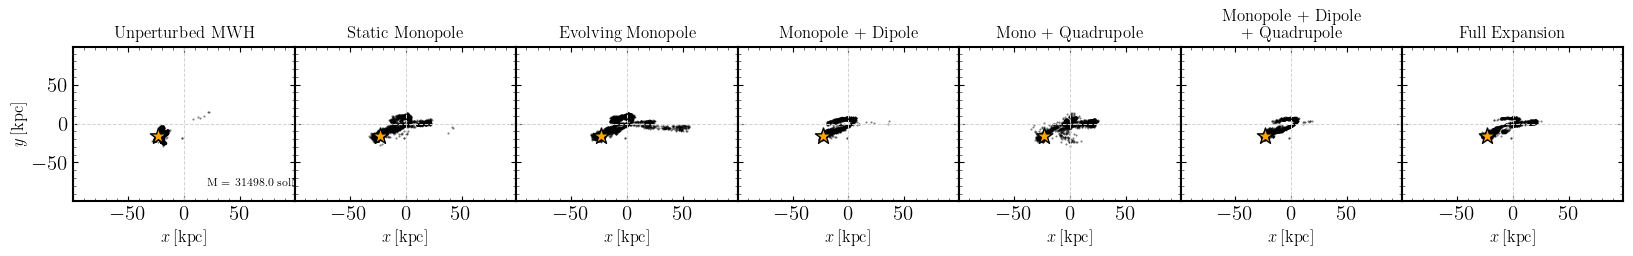

In [3]:
fig, ax = plt.subplots(1, len(potentials), sharex='col', sharey='row', figsize=(20,2)) 
plt.subplots_adjust(hspace=0, wspace=0.)
    
for j in range(len(potentials)): 

    data_path = "/mnt/ceph/users/rbrooks/oceanus/analysis/stream-runs/stream550/" + potentials[j]
    with h5py.File(data_path,'r') as file:

        prog = gd.PhaseSpacePosition(file["positions"][t_idx, 0] * u.kpc, file["velocities"][t_idx, 0] * u.km / u.s)
        stream = gd.PhaseSpacePosition(file["positions"][t_idx, 1:].T * u.kpc, file["velocities"][t_idx, 1:].T * u.km / u.s)
        start_times = np.array(file['times'])
        prog_mass = np.array(file['progenitor-mass']) * u.Msun


    plt.sca(ax[j])
    plt.hlines(0, -200, 200, ls='dashed', color='lightgrey', lw=0.7)
    plt.vlines(0, -200, 200, ls='dashed', color='lightgrey', lw=0.7)
    plot=plt.plot(stream.x, stream.y, color='k',
                     marker="o",ls="none",alpha=0.5,mew=0,ms=1.5,rasterized=True, zorder=1)
    plt.scatter(prog.x, prog.y, s=150, edgecolors='k', facecolor='orange',marker='*', label='Prog.', rasterized=True, zorder=10)

    if j==0:
        plt.annotate(text='{}'.format('stream550'), xy=(-170,70), fontsize=8 )
        plt.annotate(text=r'M = {}'.format(np.round(prog_mass, 0)), xy=(20,-80), fontsize=8)

for k in range(len(labels)):

    ax[k].set_title(labels[k])
    ax[k].set_xlabel(r'$x\,[\mathrm{kpc}]$')
    ax[k].set_xlim(-99,99)

ax[0].set_ylabel(r'$y\,[\mathrm{kpc}]$')
ax[0].set_ylim(-99,99)

(-99.0, 99.0)

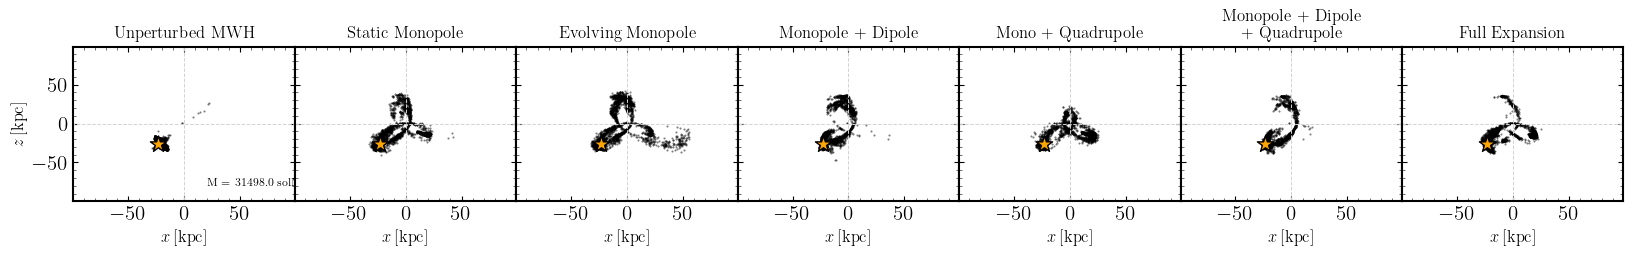

In [4]:
fig, ax = plt.subplots(1, len(potentials), sharex='col', sharey='row', figsize=(20,2)) 
plt.subplots_adjust(hspace=0, wspace=0.)
    
for j in range(len(potentials)): 

    data_path = "/mnt/ceph/users/rbrooks/oceanus/analysis/stream-runs/stream550/" + potentials[j]
    with h5py.File(data_path,'r') as file:

        prog = gd.PhaseSpacePosition(file["positions"][t_idx, 0] * u.kpc, file["velocities"][t_idx, 0] * u.km / u.s)
        stream = gd.PhaseSpacePosition(file["positions"][t_idx, 1:].T * u.kpc, file["velocities"][t_idx, 1:].T * u.km / u.s)
        start_times = np.array(file['times'])
        prog_mass = np.array(file['progenitor-mass']) * u.Msun


    plt.sca(ax[j])
    plt.hlines(0, -200, 200, ls='dashed', color='lightgrey', lw=0.7)
    plt.vlines(0, -200, 200, ls='dashed', color='lightgrey', lw=0.7)
    plot=plt.plot(stream.x, stream.z, color='k',
                     marker="o",ls="none",alpha=0.5,mew=0,ms=1.5,rasterized=True, zorder=1)
    plt.scatter(prog.x, prog.z, s=150, edgecolors='k', facecolor='orange',marker='*', label='Prog.', rasterized=True, zorder=10)

    if j==0:
        plt.annotate(text='{}'.format('stream550'), xy=(-170,70), fontsize=8 )
        plt.annotate(text=r'M = {}'.format(np.round(prog_mass, 0)), xy=(20,-80), fontsize=8)

for k in range(len(labels)):

    ax[k].set_title(labels[k])
    ax[k].set_xlabel(r'$x\,[\mathrm{kpc}]$')
    ax[k].set_xlim(-99,99)

ax[0].set_ylabel(r'$z\,[\mathrm{kpc}]$')
ax[0].set_ylim(-99,99)

(-99.0, 99.0)

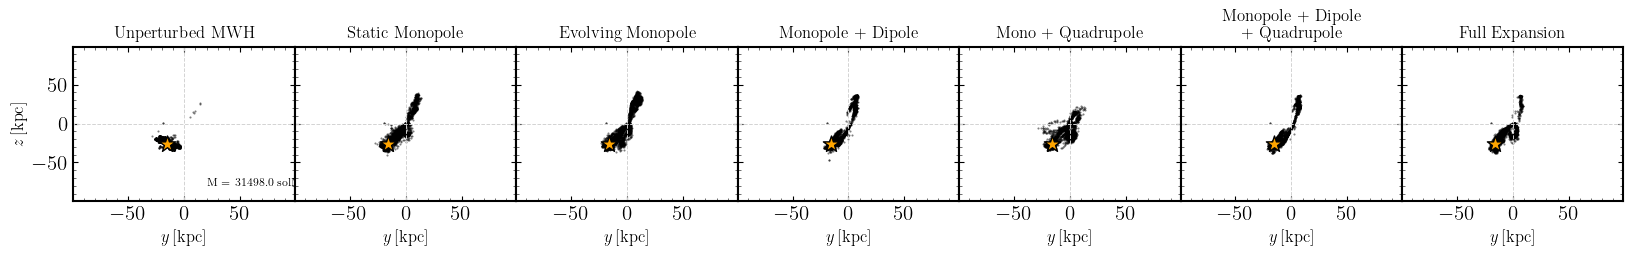

In [5]:
fig, ax = plt.subplots(1, len(potentials), sharex='col', sharey='row', figsize=(20,2)) 
plt.subplots_adjust(hspace=0, wspace=0.)
    
for j in range(len(potentials)): 

    data_path = "/mnt/ceph/users/rbrooks/oceanus/analysis/stream-runs/stream550/" + potentials[j]
    with h5py.File(data_path,'r') as file:

        prog = gd.PhaseSpacePosition(file["positions"][t_idx, 0] * u.kpc, file["velocities"][t_idx, 0] * u.km / u.s)
        stream = gd.PhaseSpacePosition(file["positions"][t_idx, 1:].T * u.kpc, file["velocities"][t_idx, 1:].T * u.km / u.s)
        start_times = np.array(file['times'])
        prog_mass = np.array(file['progenitor-mass']) * u.Msun


    plt.sca(ax[j])
    plt.hlines(0, -200, 200, ls='dashed', color='lightgrey', lw=0.7)
    plt.vlines(0, -200, 200, ls='dashed', color='lightgrey', lw=0.7)
    plot=plt.plot(stream.y, stream.z, color='k',
                     marker="o",ls="none",alpha=0.5,mew=0,ms=1.5,rasterized=True, zorder=1)
    plt.scatter(prog.y, prog.z, s=150, edgecolors='k', facecolor='orange',marker='*', label='Prog.', rasterized=True, zorder=10)

    if j==0:
        plt.annotate(text='{}'.format('stream550'), xy=(-170,70), fontsize=8 )
        plt.annotate(text=r'M = {}'.format(np.round(prog_mass, 0)), xy=(20,-80), fontsize=8)

for k in range(len(labels)):

    ax[k].set_title(labels[k])
    ax[k].set_xlabel(r'$y\,[\mathrm{kpc}]$')
    ax[k].set_xlim(-99,99)

ax[0].set_ylabel(r'$z\,[\mathrm{kpc}]$')
ax[0].set_ylim(-99,99)

In [ ]:
# def plot_stream_frames(streams, path, plotname, savefig=False):
    
#     potentials = list(['rm-MWhalo-full-MWdisc-full-LMC.hdf5', 'em-MWhalo-full-MWdisc-full-LMC.hdf5', 'md-MWhalo-full-MWdisc-full-LMC.hdf5', \
#                        'mq-MWhalo-full-MWdisc-full-LMC.hdf5', 'mdq-MWhalo-full-MWdisc-full-LMC.hdf5', 'Full-MWhalo-MWdisc-LMC.hdf5', \
#                        'full-MWhalo-full-MWdisc-no-LMC.hdf5'])
#     labels = list(['Static Monopole', 'Evolving Monopole', 'Monopole + Dipole', 'Mono + Quadrupole', \
#                       'Monopole + Dipole \n + Quadrupole', 'Full Expansion', 'Full Expansion \n (no LMC)'])
    
#     t_idx = -1
    
#     fig, ax = plt.subplots(len(streams), len(potentials), sharex='col', sharey='row', figsize=(17,5))
#     plt.subplots_adjust(hspace=0, wspace=0.)
    
#     for i in range(len(streams)): 
#         for j in range(len(potentials)):   
    
#             #-------------------------------------------------------------------------------------
#             ### Read in the data
#             #-------------------------------------------------------------------------------------
#             data_path = pathlib.Path(path) / potentials[j]
#             with h5py.File(data_path,'r') as file:
        
#                 pos = np.array(file[streams[i]]['positions'])
#                 vel = np.array(file[streams[i]]['velocities'])
#                 start_times = np.array(file[streams[i]]['times'])
#                 prog_mass = np.array(file[streams[i]]['progenitor-mass'])
                  
#             #-------------------------------------------------------------------------------------
#             ### Find the progentior Galactic coordiantes
#             #-------------------------------------------------------------------------------------
#             t0_pos, t0_vel = pos[-1], vel[-1]
#             t0_prog_pos, t0_prog_vel = t0_pos[0], t0_vel[0]
#             prog_xyz = CartesianRepresentation(t0_prog_pos[0]*u.kpc, y=t0_prog_pos[1]*u.kpc, z=t0_prog_pos[2]*u.kpc)
#             prog_Vxyz = CartesianRepresentation(t0_prog_vel[0], y=t0_prog_vel[1], z=t0_prog_vel[2])
#             GC_sph = prog_xyz.represent_as(SphericalRepresentation)
#             prog_lon, prog_lat = GC_sph.lon.deg, GC_sph.lat.deg        
     
#             #-------------------------------------------------------------------------------------
#             ### Rotation matrix for progenitor to get it to near (X, 0, 0)
#             #-------------------------------------------------------------------------------------
#             R1 = Rotation.from_euler('z', -prog_lon, degrees=True)
#             R2 = Rotation.from_euler('y', prog_lat, degrees=True)
#             R_prog0 = R2.as_matrix() @ R1.as_matrix() 
            
#             #-------------------------------------------------------------------------------------
#             ### Rotate the progenitor xyx and V_xyz
#             #-------------------------------------------------------------------------------------
#             rot_prog_pos = R_prog0 @ t0_prog_pos
#             rot_prog_vel = R_prog0 @ t0_prog_vel
            
#             #-------------------------------------------------------------------------------------
#             ### Rotate around new x axis so stream prog vel points along +y direction
#             #-------------------------------------------------------------------------------------
#             vel_rot = (np.arctan2(rot_prog_vel[2], rot_prog_vel[1])*u.rad).to(u.deg)
#             R3 = Rotation.from_euler('x', vel_rot.value, degrees=True).as_matrix() 
#             R_progf = R3 @ R_prog0
#             # R_progf = (R3 * R2 * R1).as_matrix()
            
#             #-------------------------------------------------------------------------------------
#             ### Rotate the whole stream by the final rotation matrix
#             #-------------------------------------------------------------------------------------
            
#             rot_stream_xs = np.dot(R_progf, t0_pos.T).T
#             rot_stream_vs = np.dot(R_progf, t0_vel.T).T
#             #-------------------------------------------------------------------------------------
#             ### Plot the streams
#             #-------------------------------------------------------------------------------------
                
#             plt.sca(ax[i,j])
#             print('* Plotting {} in potential {}'.format(streams[i], potentials[j]))
#             plt.hlines(0, -200, 200, ls='dashed', color='lightgrey', lw=0.7)
#             plt.vlines(0, -200, 200, ls='dashed', color='lightgrey', lw=0.7)
#             plot=plt.scatter(rot_stream_xs[:,1],rot_stream_xs[:,2], s=1, c=start_times, cmap = 'viridis',rasterized=True)
#             plt.scatter(rot_stream_xs[0][1],rot_stream_xs[0][2], s=200, edgecolors='k', facecolor='orange',marker='*', label='Prog.', rasterized=True)
            
#             if j==0:
#                 name, ext = os.path.splitext(streams[i])
#                 plt.annotate(text='{}'.format(name), xy=(-35,15), fontsize=8)
            
#     cb = fig.colorbar(plot,  ax=ax, location='right', aspect=30, pad=0.01)
#     cb.set_label('Stripping time [Gyr]')
#     cb.ax.tick_params(labelsize=12)
    
#     #-------------------------------------------------------------------------------------
#     ### Plot cosmetics
#     #-------------------------------------------------------------------------------------
    
#     lgd = ax[2,0].legend(frameon=False, fontsize=8, loc='lower left')
#     lgd.legend_handles[0]._sizes = [75]
            
#     for k in range(len(labels)):

#         ax[0,k].set_title(labels[k])
#         ax[len(streams)-1,k].set_xlabel(r'$y^{\prime}\,[\mathrm{kpc}]$')
#         ax[len(streams)-1,k].set_xlim(-39,39)
        
#     for l in range(len(streams)):
#         ax[l, 0].set_ylabel(r'$z^{\prime}\,[\mathrm{kpc}]$')
#         ax[l, 0].set_ylim(-19,19)

#     if savefig==False:
#         return
#     elif savefig==True:
#         return plt.savefig('/mnt/ceph/users/rbrooks/oceanus/analysis/figures/{}'.format(plotname))

In [174]:
def plot_stream_frames(streams, path, plotname, savefig=False):
    
    potentials = list(['static-mwh-only.hdf5','rm-MWhalo-full-MWdisc-full-LMC.hdf5', 'em-MWhalo-full-MWdisc-full-LMC.hdf5',\
                       'md-MWhalo-full-MWdisc-full-LMC.hdf5', 'mq-MWhalo-full-MWdisc-full-LMC.hdf5', 'mdq-MWhalo-full-MWdisc-full-LMC.hdf5',\
                       'Full-MWhalo-MWdisc-LMC.hdf5', 'full-MWhalo-full-MWdisc-no-LMC.hdf5'])
    
    labels = list(['Static MW','Static Monopole', 'Evolving Monopole', 'Monopole + Dipole', 'Mono + Quadrupole', \
                   'Monopole + Dipole \n + Quadrupole', 'Full Expansion', 'Full Expansion \n (no LMC)'])
              
    t_idx = -1
    
    fig, ax = plt.subplots(len(streams), len(potentials), sharex='col', sharey='row', figsize=(21,6))
    plt.subplots_adjust(hspace=0, wspace=0.)
    
    for j in range(len(potentials)): 
        for i in range(len(streams)):   
            #-------------------------------------------------------------------------------------
            ### Read in the data
            #-------------------------------------------------------------------------------------
            data_path = pathlib.Path(path) / potentials[j]
            with h5py.File(data_path,'r') as file:
        
                prog = gd.PhaseSpacePosition(file[streams[i]]["positions"][t_idx, 0] * u.kpc, file[streams[i]]["velocities"][t_idx, 0] * u.km / u.s)
                stream = gd.PhaseSpacePosition(file[streams[i]]["positions"][t_idx, 1:].T * u.kpc, file[streams[i]]["velocities"][t_idx, 1:].T * u.km / u.s)
                start_times = np.array(file[streams[i]]['times'])
                prog_mass = np.array(file[streams[i]]['progenitor-mass']) * u.Msun
                rlmc = np.array(file[streams[i]]['lmc_sep'])
            #-------------------------------------------------------------------------------------
            ### Rotation matrix for progenitor to get it to near (X, 0, 0)
            #-------------------------------------------------------------------------------------
            R1 = Rotation.from_euler("z", -prog.spherical.lon.degree, degrees=True)
            R2 = Rotation.from_euler("y", prog.spherical.lat.degree, degrees=True)
            R_prog0 = R2.as_matrix() @ R1.as_matrix()  
            #-------------------------------------------------------------------------------------
            ### Rotate around new x axis so stream prog vel points along +y direction
            #-------------------------------------------------------------------------------------
            new_vxyz = R_prog0 @ prog.v_xyz
            v_angle = np.arctan2(new_vxyz[2], new_vxyz[1])
            R3 = Rotation.from_euler("x", -v_angle.to_value(u.degree), degrees=True)
            R = (R3 * R2 * R1).as_matrix()
            #-------------------------------------------------------------------------------------
            ### Rotate the whole stream by the final rotation matrix
            #-------------------------------------------------------------------------------------
            prog_rot = gd.PhaseSpacePosition(prog.data.transform(R))
            prog_sph = prog_rot.spherical
            stream_rot = gd.PhaseSpacePosition(stream.data.transform(R))
            stream_sph = stream_rot.spherical
            lon = stream_sph.lon.wrap_at(180*u.deg).degree[:-2]
            lat = stream_sph.lat.degree[:-2]
            #-------------------------------------------------------------------------------------
            ### Plot the streams
            #-------------------------------------------------------------------------------------
            plt.sca(ax[i,j])
            print('* Plotting {} in potential {}'.format(streams[i], potentials[j]))
            plt.hlines(0, -200, 200, ls='dashed', color='lightgrey', lw=0.7, zorder=1)
            plt.vlines(0, -200, 200, ls='dashed', color='lightgrey', lw=0.7, zorder=1)
            plot=plt.scatter(lon, lat, s=.5, c=start_times, cmap = 'viridis',rasterized=True, zorder=2)
            
            if j==0:
                name, ext = os.path.splitext(streams[i])
                plt.annotate(text='{}'.format(name), xy=(-180,65), fontsize=8 )
                plt.annotate(text=r'M = {} $\times \, 10^{{4}} \, \mathrm{{M}}_{{\odot}}$'.format(np.round(prog_mass.value/1e4, 1)),
                             xy=(-180, -80), fontsize=8)
            
    cb = fig.colorbar(plot,  ax=ax, location='right', aspect=30, pad=0.01)
    cb.set_label('Stripping time [Gyr]')
    cb.ax.tick_params(labelsize=12)
    
    #-------------------------------------------------------------------------------------
    ### Plot cosmetics
    #-------------------------------------------------------------------------------------
    for k in range(len(labels)):

        ax[0,k].set_title(labels[k])
        ax[len(streams)-1,k].set_xlabel(r'$\mathrm{lon}\,[^{\circ}]$')
        ax[len(streams)-1,k].set_xlim(-199,199)
        
    for l in range(len(streams)):
        ax[l, 0].set_ylabel(r'$\mathrm{lat}\,[^{\circ}]$')
        ax[l, 0].set_ylim(-99,99)

    if savefig==False:
        return
    elif savefig==True:
        return plt.savefig('/mnt/ceph/users/rbrooks/oceanus/analysis/figures/{}'.format(plotname))

* Plotting stream_0 in potential static-mwh-only.hdf5
* Plotting stream_1 in potential static-mwh-only.hdf5
* Plotting stream_2 in potential static-mwh-only.hdf5
* Plotting stream_3 in potential static-mwh-only.hdf5
* Plotting stream_4 in potential static-mwh-only.hdf5
* Plotting stream_0 in potential rm-MWhalo-full-MWdisc-full-LMC.hdf5
* Plotting stream_1 in potential rm-MWhalo-full-MWdisc-full-LMC.hdf5
* Plotting stream_2 in potential rm-MWhalo-full-MWdisc-full-LMC.hdf5
* Plotting stream_3 in potential rm-MWhalo-full-MWdisc-full-LMC.hdf5
* Plotting stream_4 in potential rm-MWhalo-full-MWdisc-full-LMC.hdf5
* Plotting stream_0 in potential em-MWhalo-full-MWdisc-full-LMC.hdf5
* Plotting stream_1 in potential em-MWhalo-full-MWdisc-full-LMC.hdf5
* Plotting stream_2 in potential em-MWhalo-full-MWdisc-full-LMC.hdf5
* Plotting stream_3 in potential em-MWhalo-full-MWdisc-full-LMC.hdf5
* Plotting stream_4 in potential em-MWhalo-full-MWdisc-full-LMC.hdf5
* Plotting stream_0 in potential md-MWha

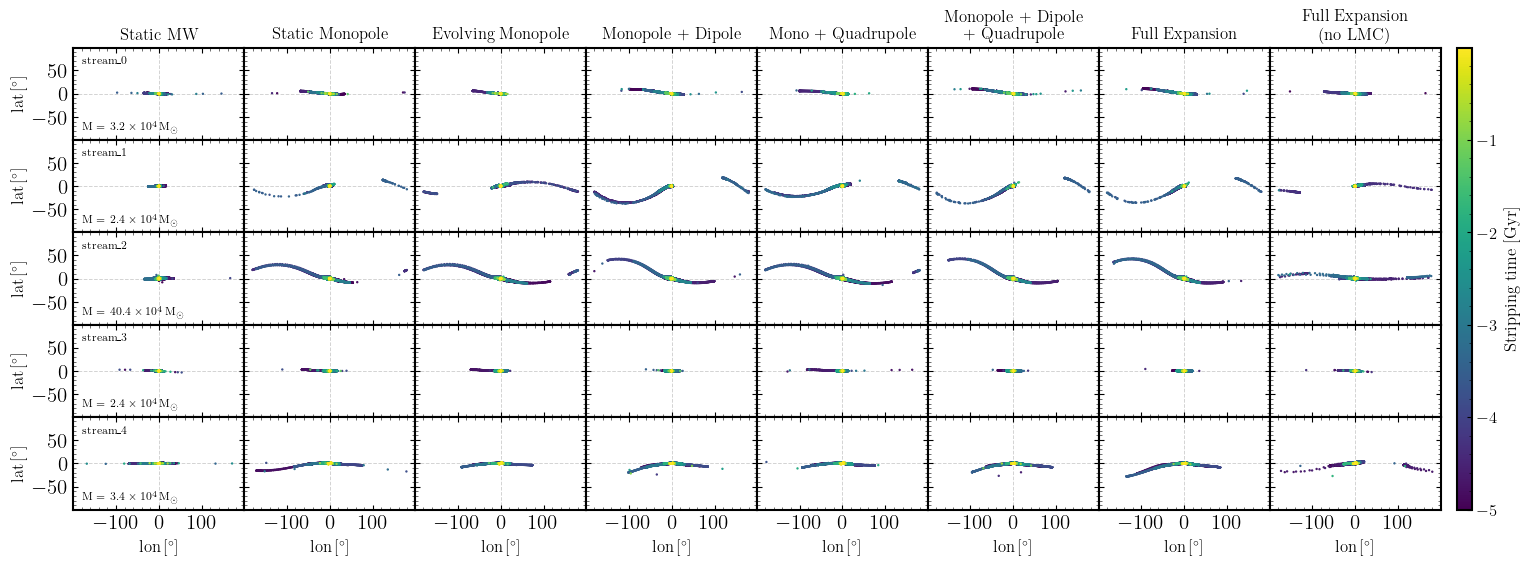

In [175]:
streams = list(['stream_0', 'stream_1','stream_2','stream_3','stream_4', ]) 
# streams = list(['stream_20', 'stream_21','stream_22','stream_23','stream_24',]) 
path = '/mnt/ceph/users/rbrooks/oceanus/analysis/stream-runs/combined-files/'
plotname = 'plot_stream_coords'
plot_stream_frames(streams, path, plotname, False)

In [30]:
def plot_stream_cartesian(streams, path, plotname, savefig=False):
    
    potentials = list(['static-mwh-only.hdf5','rm-MWhalo-full-MWdisc-full-LMC.hdf5', 'em-MWhalo-full-MWdisc-full-LMC.hdf5', 'md-MWhalo-full-MWdisc-full-LMC.hdf5', \
                       'mq-MWhalo-full-MWdisc-full-LMC.hdf5', 'mdq-MWhalo-full-MWdisc-full-LMC.hdf5', 'Full-MWhalo-MWdisc-LMC.hdf5', \
                       'full-MWhalo-full-MWdisc-no-LMC.hdf5'])
    labels = list(['Static MW','Static Monopole', 'Evolving Monopole', 'Monopole + Dipole', 'Mono + Quadrupole', \
                      'Monopole + Dipole \n + Quadrupole', 'Full Expansion', 'Full Expansion \n (no LMC)'])
    
    fig_yz, ax = plt.subplots(len(streams), len(potentials), sharex='col', sharey='row', figsize=(19,5))
    plt.subplots_adjust(hspace=0, wspace=0.)
    
    for i in range(len(streams)): 
        for j in range(len(potentials)):   
    
            #-------------------------------------------------------------------------------------
            ### Read in the data
            #-------------------------------------------------------------------------------------
            data_path = pathlib.Path(path) / potentials[j]
            with h5py.File(data_path,'r') as file:
    
                pos = np.array(file[streams[i]]['positions'])
                vel = np.array(file[streams[i]]['velocities'])
                start_times = np.array(file[streams[i]]['times'])
                prog_mass = np.array(file[streams[i]]['progenitor-mass'])
                  
            #-------------------------------------------------------------------------------------
            ### Find the progentior Galactic coordiantes
            #-------------------------------------------------------------------------------------
            t0_pos, t0_vel = pos[-1], vel[-1]
            t0_prog_pos, t0_prog_vel = t0_pos[0], t0_vel[0]
            prog_xyz = CartesianRepresentation(t0_prog_pos[0]*u.kpc, y=t0_prog_pos[1]*u.kpc, z=t0_prog_pos[2]*u.kpc)
            
            #-------------------------------------------------------------------------------------
            ### Plot the streams
            #-------------------------------------------------------------------------------------
                
            plt.sca(ax[i,j])
            # print('* Plotting {} in potential {}'.format(streams[i], potentials[j]))
            plot=plt.scatter(t0_pos[:,1][1:-2],t0_pos[:,2][1:-2], s=1, c=start_times, cmap = 'viridis',rasterized=True)
            plt.scatter(prog_xyz.y, prog_xyz.z, s=50, edgecolors='k', facecolor='orange',marker='*', label='Prog.', rasterized=True)
            
            # if j==0:
            #     name, ext = os.path.splitext(streams[i])
            #     plt.annotate(text='{}'.format(name), xy=(-35,15), fontsize=8)
            
    cb = fig_yz.colorbar(plot,  ax=ax, location='right', aspect=30, pad=0.01)
    cb.set_label('Stripping time [Gyr]')
    cb.ax.tick_params(labelsize=12)
    
    #-------------------------------------------------------------------------------------
    ### Plot cosmetics
    #-------------------------------------------------------------------------------------
    # lgd = ax[2,0].legend(frameon=False, fontsize=8, loc='lower left')
            
    for k in range(len(labels)):

        ax[0,k].set_title(labels[k])
        ax[len(streams)-1,k].set_xlabel(r'$y\,[\mathrm{kpc}]$')
        
    for l in range(len(streams)):
        ax[l, 0].set_ylabel(r'$z\,[\mathrm{kpc}]$')

    if savefig==True:
        plt.savefig('/mnt/ceph/users/rbrooks/oceanus/analysis/figures/{}'.format(plotname + '_yz'))
        
    fig_xy, ax = plt.subplots(len(streams), len(potentials), sharex='col', sharey='row', figsize=(17,5))
    plt.subplots_adjust(hspace=0, wspace=0.)
    
    for i in range(len(streams)): 
        for j in range(len(potentials)):   
    
            #-------------------------------------------------------------------------------------
            ### Read in the data
            #-------------------------------------------------------------------------------------
            data_path = pathlib.Path(path) / potentials[j]
            with h5py.File(data_path,'r') as file:
    
                pos = np.array(file[streams[i]]['positions'])
                vel = np.array(file[streams[i]]['velocities'])
                start_times = np.array(file[streams[i]]['times'])
                prog_mass = np.array(file[streams[i]]['progenitor-mass'])
                  
            #-------------------------------------------------------------------------------------
            ### Find the progentior Galactic coordiantes
            #-------------------------------------------------------------------------------------
            t0_pos, t0_vel = pos[-1], vel[-1]
            t0_prog_pos, t0_prog_vel = t0_pos[0], t0_vel[0]
            prog_xyz = CartesianRepresentation(t0_prog_pos[0]*u.kpc, y=t0_prog_pos[1]*u.kpc, z=t0_prog_pos[2]*u.kpc)
            
            #-------------------------------------------------------------------------------------
            ### Plot the streams
            #-------------------------------------------------------------------------------------
                
            plt.sca(ax[i,j])
            # print('* Plotting {} in potential {}'.format(streams[i], potentials[j]))
            plot=plt.scatter(t0_pos[:,0][1:-2],t0_pos[:,1][1:-2], s=1, c=start_times, cmap = 'viridis',rasterized=True)
            plt.scatter(prog_xyz.x, prog_xyz.y, s=50, edgecolors='k', facecolor='orange',marker='*', label='Prog.', rasterized=True)
            
            # if j==0:
            #     name, ext = os.path.splitext(streams[i])
            #     plt.annotate(text='{}'.format(name), xy=(-35,15), fontsize=8)
            
    cb = fig_xy.colorbar(plot,  ax=ax, location='right', aspect=30, pad=0.01)
    cb.set_label('Stripping time [Gyr]')
    cb.ax.tick_params(labelsize=12)
    
    #-------------------------------------------------------------------------------------
    ### Plot cosmetics
    #-------------------------------------------------------------------------------------
    
    # lgd = ax[2,0].legend(frameon=False, fontsize=8, loc='lower left')
            
    for k in range(len(labels)):

        ax[0,k].set_title(labels[k])
        ax[len(streams)-1,k].set_xlabel(r'$x\,[\mathrm{kpc}]$')
        
    for l in range(len(streams)):
        ax[l, 0].set_ylabel(r'$y\,[\mathrm{kpc}]$')
        
    if savefig==True:
        plt.savefig('/mnt/ceph/users/rbrooks/oceanus/analysis/figures/{}'.format(plotname + '_xy'))
    
    fig_xz, ax = plt.subplots(len(streams), len(potentials), sharex='col', sharey='row', figsize=(17,5))
    plt.subplots_adjust(hspace=0, wspace=0.)
    
    for i in range(len(streams)): 
        for j in range(len(potentials)):   
    
            #-------------------------------------------------------------------------------------
            ### Read in the data
            #-------------------------------------------------------------------------------------
            data_path = pathlib.Path(path) / potentials[j]
            with h5py.File(data_path,'r') as file:
    
                pos = np.array(file[streams[i]]['positions'])
                vel = np.array(file[streams[i]]['velocities'])
                start_times = np.array(file[streams[i]]['times'])
                prog_mass = np.array(file[streams[i]]['progenitor-mass'])
                  
            #-------------------------------------------------------------------------------------
            ### Find the progentior Galactic coordiantes
            #-------------------------------------------------------------------------------------
            t0_pos, t0_vel = pos[-1], vel[-1]
            t0_prog_pos, t0_prog_vel = t0_pos[0], t0_vel[0]
            prog_xyz = CartesianRepresentation(t0_prog_pos[0]*u.kpc, y=t0_prog_pos[1]*u.kpc, z=t0_prog_pos[2]*u.kpc)
            
            #-------------------------------------------------------------------------------------
            ### Plot the streams
            #-------------------------------------------------------------------------------------
                
            plt.sca(ax[i,j])
            # print('* Plotting {} in potential {}'.format(streams[i], potentials[j]))
            plot=plt.scatter(t0_pos[:,0][1:-2],t0_pos[:,2][1:-2], s=1, c=start_times, cmap = 'viridis',rasterized=True)
            plt.scatter(prog_xyz.x, prog_xyz.z, s=50, edgecolors='k', facecolor='orange',marker='*', label='Prog.', rasterized=True)
            
            # if j==0:
            #     name, ext = os.path.splitext(streams[i])
            #     plt.annotate(text='{}'.format(name), xy=(-35,15), fontsize=8)
            
    cb = fig_xz.colorbar(plot,  ax=ax, location='right', aspect=30, pad=0.01)
    cb.set_label('Stripping time [Gyr]')
    cb.ax.tick_params(labelsize=12)
    
    #-------------------------------------------------------------------------------------
    ### Plot cosmetics
    #-------------------------------------------------------------------------------------
    # lgd = ax[2,0].legend(frameon=False, fontsize=8, loc='lower left')
     
    for k in range(len(labels)):

        ax[0,k].set_title(labels[k])
        ax[len(streams)-1,k].set_xlabel(r'$x\,[\mathrm{kpc}]$')
        
    for l in range(len(streams)):
        ax[l, 0].set_ylabel(r'$z\,[\mathrm{kpc}]$')

    if savefig==True:
        plt.savefig('/mnt/ceph/users/rbrooks/oceanus/analysis/figures/{}'.format(plotname + '_xz'))

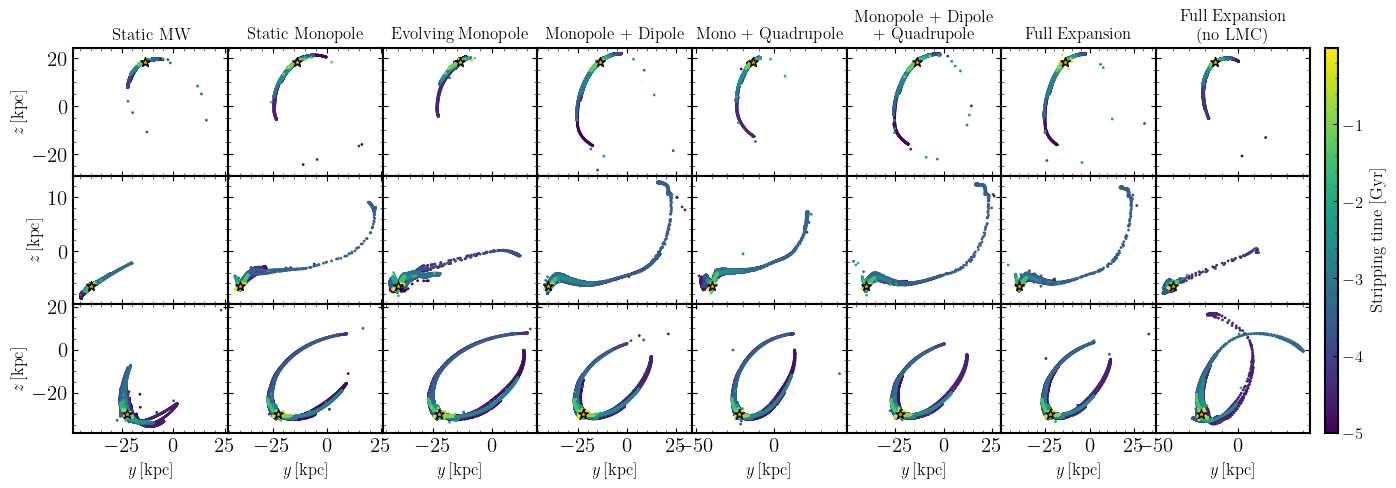

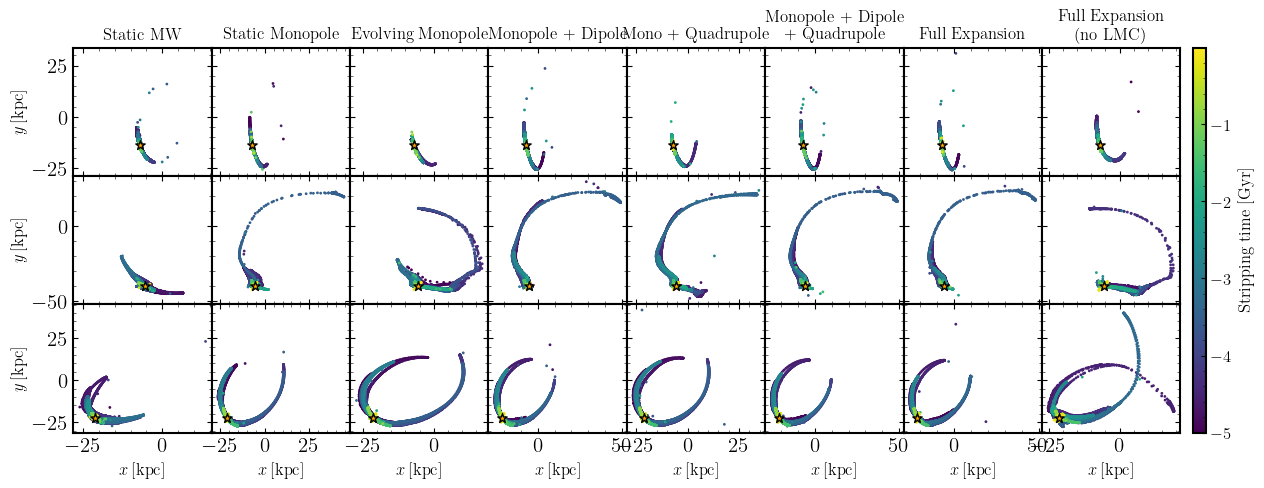

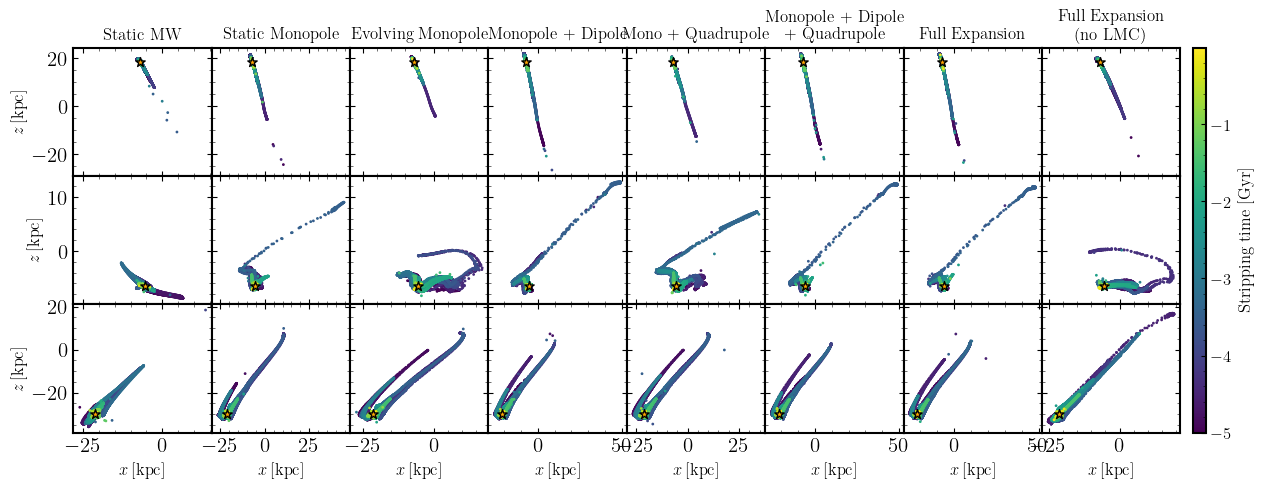

In [31]:
streams = list(['stream_0', 'stream_1', 'stream_2']) 
path = '/mnt/ceph/users/rbrooks/oceanus/analysis/stream-runs/combined-files/'
plotname = 'stream_cartesian'

plot_stream_cartesian(streams, path, plotname, True)

### Plotting summary statistics

In [335]:
path = '/mnt/ceph/users/rbrooks/oceanus/analysis/stream-runs/combined-files/'

veldis_rv = []
rgal = []
peris = []
apos = []
widths = []
lengths = []
veldis = []
lmc_sep = []
pole_b = []
pole_b_dis = []
pole_l = []
pole_l_dis = []
masses = []
energy = []
Ls = []
Lzs = []

Nstreams = 128
for i in range(Nstreams):
    data_path = pathlib.Path(path) / 'Full-MWhalo-MWdisc-LMC.hdf5'
    with h5py.File(data_path,'r') as file:
        
#         pos = np.array(file['stream_{}'.format(i)]['positions'])[-1]
#         vel = np.array(file['stream_{}'.format(i)]['velocities'])[-1]

#         galactocentric = SkyCoord(x=np.array(pos)[:,0]*u.kpc, y=np.array(pos)[:,1]*u.kpc, z=np.array(pos)[:,2]*u.kpc,
#                          v_x=np.array(vel)[:,0]*u.km/u.s, v_y=np.array(vel)[:,1]*u.km/u.s, v_z=np.array(vel)[:,2]*u.km/u.s,
#                                   frame='galactocentric')
#         galactic = galactocentric.transform_to('galactic')
#         galactic_rc = gc.reflex_correct(galactic)
        
#         veldis_rv.append(np.nanstd(galactic_rc.radial_velocity.value))

        rgal.append( np.nanmedian(np.linalg.norm(np.array(file['stream_{}'.format(i)]['positions'])[-1],axis=1)) )
        peris.append(np.array(file['stream_{}'.format(i)]['pericenter']))
        apos.append(np.array(file['stream_{}'.format(i)]['apocenter']))
        widths.append(np.array(file['stream_{}'.format(i)]['width']))
        lengths.append(np.array(file['stream_{}'.format(i)]['length']))
        veldis.append(np.array(file['stream_{}'.format(i)]['vel_dispersion']))
        lmc_sep.append(np.array(file['stream_{}'.format(i)]['lmc_sep']))
        pole_b.append(np.nanmedian(np.array(file['stream_{}'.format(i)]['pole_b'])[-1]))
        pole_l.append(np.nanmedian(np.array(file['stream_{}'.format(i)]['pole_l'])[-1]))
        pole_b_dis.append(np.nanstd(np.array(file['stream_{}'.format(i)]['pole_b'])[-1]))
        pole_l_dis.append(np.nanstd(np.array(file['stream_{}'.format(i)]['pole_l'])[-1]))
        masses.append(np.array(file['stream_{}'.format(i)]['progenitor-mass']))
        energy.append(np.nanmedian(np.array(file['stream_{}'.format(i)]['energies'])[-1]))
        Ls.append(np.nanmedian(np.array(file['stream_{}'.format(i)]['L'])[-1]))
        Lzs.append(np.nanmedian(np.array(file['stream_{}'.format(i)]['Lz'])[-1]))

In [336]:
# plt.scatter(veldis_rv, veldis)
# plt.plot(np.linspace(0,200,10), np.linspace(0,200,10), c='k')

Histogram of poles

In [375]:
path = '/mnt/ceph/users/rbrooks/oceanus/analysis/stream-runs/combined-files/'
def pole_hist(path, plotname, savefig=False):
    
    potentials = list(['static-mwh-only.hdf5','rm-MWhalo-full-MWdisc-full-LMC.hdf5', 'em-MWhalo-full-MWdisc-full-LMC.hdf5', 'md-MWhalo-full-MWdisc-full-LMC.hdf5', \
                       'mq-MWhalo-full-MWdisc-full-LMC.hdf5', 'mdq-MWhalo-full-MWdisc-full-LMC.hdf5', 'Full-MWhalo-MWdisc-LMC.hdf5', \
                       'full-MWhalo-full-MWdisc-no-LMC.hdf5'])
    # potentials = list(['static-mwh-only.hdf5', 'Full-MWhalo-MWdisc-LMC.hdf5','full-MWhalo-full-MWdisc-no-LMC.hdf5'])
    labels = list(['Static MW','Static Monopole', 'Evolving Monopole', 'Monopole + Dipole', 'Mono + Quadrupole', \
                      'Monopole + Dipole \n + Quadrupole', 'Full Expansion', 'Full Expansion \n (no LMC)'])
    # labels = list(['Static MW', 'Full Expansion', 'Full Expansion \n (no LMC)'])
    
    fig, ax = plt.subplots(1,1, figsize=(5,2.5))

    Nstreams = 128
    for j in range(len(potentials)):    
        data_path = pathlib.Path(path) / potentials[j]
        pole_b = []
        for i in range(Nstreams):
            with h5py.File(data_path,'r') as file:

                pole_b.append(np.nanmedian(np.array(file['stream_{}'.format(i)]['pole_b'])[-1]))
                
        sinb = np.sin((pole_b*u.deg).to(u.rad)).value        
        plt.sca(ax)
        plt.hist(sinb, bins=np.linspace(-1,1,20), histtype='step', fill=False, label=labels[j])

    plt.xlabel('$\sin(b_{\mathrm{pole}})$')
    plt.ylabel('N')
    plt.legend(bbox_to_anchor=(1.45,1.), fontsize=9)
    
    if savefig==True:
        plt.savefig('/mnt/ceph/users/rbrooks/oceanus/analysis/figures/{}'.format(plotname))

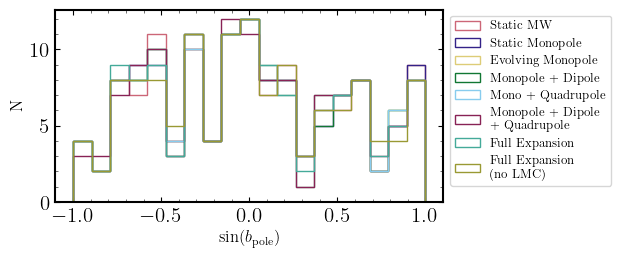

In [376]:
pole_hist(path, 'name', False)

Orbital radial phase vs velocity dispersion & Pericenter vs velocity dispersion

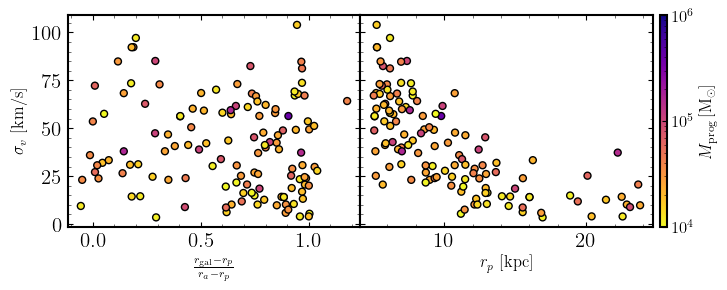

In [339]:
f = (np.array(rgal) - np.array(peris)) / (np.array(apos) - np.array(peris))
fig, ax = plt.subplots(1,2, figsize=(9,2.75), sharey='row')

plt.subplots_adjust(wspace=0.)
plt.sca(ax[0])
plot=plt.scatter(f, veldis, c=masses, cmap='plasma_r', edgecolor='k',
               norm=matplotlib.colors.LogNorm(vmin=1e4, vmax=1e6))

plt.xlabel(r'$\frac{r_{\mathrm{gal}} - r_p}{r_a - r_p}$')
plt.ylabel('$\sigma_v$ [km/s]')

plt.sca(ax[1])
plot=plt.scatter(peris, veldis, c=masses, cmap='plasma_r', edgecolor='k',
               norm=matplotlib.colors.LogNorm(vmin=1e4, vmax=1e6))
plt.xlabel('$r_{p}$ [kpc]')

cb = fig.colorbar(plot, ax=[ax[0], ax[1]],location='right', aspect=30, pad=0.01)
cb.set_label(r'$M_{\mathrm{prog}}\,[\mathrm{M}_{\odot}$]')
cb.ax.tick_params(labelsize=12)
# plt.savefig('/mnt/ceph/users/rbrooks/oceanus/analysis/figures/static-mwh-radorbphase-peri-veldis')

Pole dispersion vs pericenters

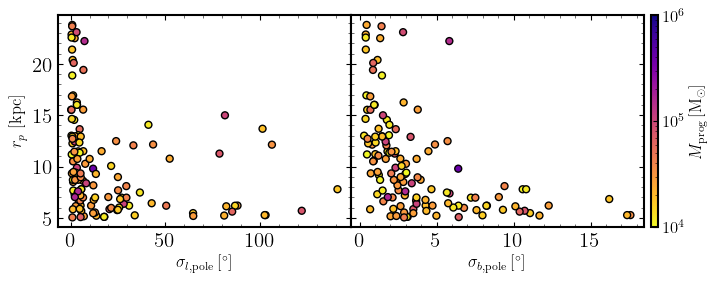

In [340]:
fig, ax = plt.subplots(1,2, figsize=(9,2.75), sharey='row')

plt.subplots_adjust(wspace=0.)
plt.sca(ax[0])
plot=plt.scatter(pole_l_dis, peris, c=masses, cmap='plasma_r', edgecolor='k',
               norm=matplotlib.colors.LogNorm(vmin=1e4, vmax=1e6))

plt.xlabel(r'$\sigma_{l,\mathrm{pole}}\,[^\circ]$')
plt.ylabel('$r_p$ [kpc]')

plt.sca(ax[1])
plot=plt.scatter(pole_b_dis, peris, c=masses, cmap='plasma_r', edgecolor='k',
               norm=matplotlib.colors.LogNorm(vmin=1e4, vmax=1e6))
plt.xlabel(r'$\sigma_{b,\mathrm{pole}}\,[^\circ]$')

cb = fig.colorbar(plot, ax=[ax[0], ax[1]],location='right', aspect=30, pad=0.01)
cb.set_label(r'$M_{\mathrm{prog}}\,[\mathrm{M}_{\odot}$]')
cb.ax.tick_params(labelsize=12)

Mollewide plot of median stream poles coloured by distance

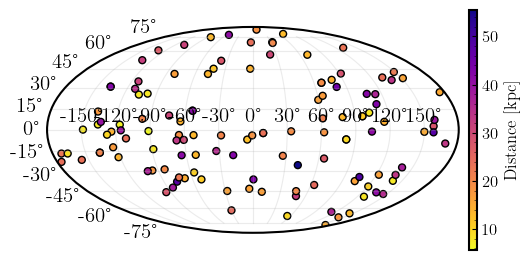

In [341]:
plt.subplot(projection="mollweide")
plt.grid(alpha=.25)
sc=plt.scatter((pole_l*u.deg).to(u.rad), (pole_b*u.deg).to(u.rad),
           c=rgal, cmap='plasma_r', edgecolor='k')

cb=plt.colorbar(sc,location='right', aspect=30, pad=0.02, shrink=.65)
cb.set_label(r'Distance [kpc]')
cb.ax.tick_params(labelsize=12)

width vs length

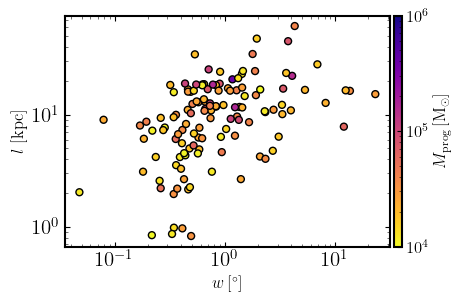

In [146]:
fig, ax = plt.subplots(1,1, figsize=(5,3))
plot=ax.scatter(widths, lengths, c=masses, cmap='plasma_r', edgecolor='k',
               norm=matplotlib.colors.LogNorm(vmin=1e4, vmax=1e6))

plt.sca(ax)
plt.xlabel('$w\,[^{\circ}]$')
plt.ylabel('$l$ [kpc]')
plt.xscale('log')
plt.yscale('log')

cb = fig.colorbar(plot, ax=ax,location='right', aspect=30, pad=0.01)
cb.set_label(r'$M_{\mathrm{prog}}\,[\mathrm{M}_{\odot}$]')
cb.ax.tick_params(labelsize=12)
# plt.savefig('/mnt/ceph/users/rbrooks/oceanus/analysis/figures/widths-lengths')